<a href="https://colab.research.google.com/github/kohathyli/Credeit-Default/blob/main/DURF_PCA_LLE_%2B_causal_model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve,auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from collections import Counter
from IPython.display import SVG, display
from graphviz import Source
from mlxtend.plotting import plot_decision_regions
from scipy.stats import randint as sp_randint

import warnings
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
df = pd.read_csv("default of credit card clients.csv")

In [ ]:
columns_to_drop = ['SEX', 'MARRIAGE', 'AGE']
df = df.drop(columns=columns_to_drop)
df.head()

,ID,LIMIT_BAL,EDUCATION,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,2,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
data_X = df.copy()
data_X = data_X.drop(['ID', 'default payment next month'], axis = 1)

In [ ]:
data_cat = df[["PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]]

In [ ]:
data_num = data_X.copy()
data_num = data_num.drop(data_cat.columns, axis = 1)
data_num = data_num.drop('EDUCATION', axis = 1)
data_num = data_num.drop('LIMIT_BAL', axis = 1)

In [ ]:
data_target = df[['default payment next month']]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
def scaleNum(df_num, cols):
    for col in cols:
        df_num[col] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(data_num[col])),columns=[col])
    return df_num
data_normal_num = scaleNum(data_num,data_num.columns)
data_normal_num.head()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.149982,0.069164,0.086723,0.160138,0.080648,0.260979,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000
1,0.148892,0.067858,0.087817,0.163220,0.084074,0.263485,0.000000,0.000594,0.001116,0.001610,0.000000,0.003783
2,0.172392,0.079532,0.093789,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458
3,0.188100,0.111995,0.113407,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892
4,0.154144,0.071601,0.106020,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
def scaleCat(df_cat, cols):
    for col in cols:
        df_cat[col] = pd.DataFrame(label_encoder.fit_transform(pd.DataFrame(data_cat[col])),columns=[col])
    return df_cat
data_normal_cat = scaleCat(data_cat,data_cat.columns)
data_normal_cat.head()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
0,4,4,1,1,0,0
1,1,4,2,2,2,3
2,2,2,2,2,2,2
3,2,2,2,2,2,2
4,1,2,1,2,2,2


In [ ]:
mapping = {
    1: 'graduate school',
    2: 'university',
    3: 'high school',
    4: 'others',
    5: 'others',
    6: 'others'
}
df['EDUCATION'] = df['EDUCATION'].map(mapping)
df['EDUCATION'].head()

0    university
1    university
2    university
3    university
4    university
Name: EDUCATION, dtype: object

In [ ]:
df_EDUCATION = pd.get_dummies(df['EDUCATION'])
df_EDUCATION.head()

,graduate school,high school,others,university
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [ ]:
df_LIMIT_BAL = np.log1p(df['LIMIT_BAL'])

In [ ]:
data_fitur = data_normal_num.merge(data_normal_cat, left_index = True, right_index = True)
data_fitur = data_fitur.merge(df_EDUCATION, left_index = True, right_index = True)
data_fitur = data_fitur.merge(df_LIMIT_BAL, left_index = True, right_index = True)
data = data_fitur.merge(data_target, left_index = True, right_index = True)
data.head()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,graduate school,high school,others,university,LIMIT_BAL,default payment next month
0,0.149982,0.069164,0.086723,0.160138,0.080648,0.260979,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000,4,4,1,1,0,0,0,0,0,1,9.903538,1
1,0.148892,0.067858,0.087817,0.163220,0.084074,0.263485,0.000000,0.000594,0.001116,0.001610,0.000000,0.003783,1,4,2,2,2,3,0,0,0,1,11.695255,1
2,0.172392,0.079532,0.093789,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458,2,2,2,2,2,2,0,0,0,1,11.407576,0
3,0.188100,0.111995,0.113407,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892,2,2,2,2,2,2,0,0,0,1,10.819798,0
4,0.154144,0.071601,0.106020,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284,1,2,1,2,2,2,0,0,0,1,10.819798,0


In [ ]:
data['TOTAL_BILL_AMT'] = df['BILL_AMT1'] + df['BILL_AMT2'] + df['BILL_AMT3'] + df['BILL_AMT4'] + df['BILL_AMT5'] + df['BILL_AMT6']
data['TOTAL_PAY_AMT'] = df['PAY_AMT1'] + df['PAY_AMT2'] + df['PAY_AMT3'] + df['PAY_AMT4'] + df['PAY_AMT5'] + df['PAY_AMT6'] 
data['OUTSTANDING'] = data['TOTAL_BILL_AMT'] - data['TOTAL_PAY_AMT']

data['MEAN_PAY_AMT'] = data['TOTAL_PAY_AMT'] / 6
data['MEAN_BILL_AMT'] = data['TOTAL_BILL_AMT'] / 6


# Ratio of Total Pay/Total Bill, if Total Bill is zero, then take Total Pay; prevent division by zero 
data['TOTAL_PAY/TOTAL_BILL'] = np.where(data['TOTAL_BILL_AMT']==0, data['TOTAL_PAY_AMT'], data['TOTAL_PAY_AMT'] / data['TOTAL_BILL_AMT'])
# The difficulty of a person to pay back the bill
data['OUTSTANDING/LIMIT_BAL'] = np.where(data['LIMIT_BAL']==0, data['OUTSTANDING'], data['OUTSTANDING'] / data['LIMIT_BAL'])

In [ ]:
cols_to_drop = [
                'MEAN_PAY_AMT', 'MEAN_BILL_AMT', # can drop these for slight increase in ROC for classifiers
                'OUTSTANDING'   # low correlation with default flag
               ]

data = data.drop(columns=cols_to_drop)

In [ ]:
from sklearn.model_selection import train_test_split

x = data.drop(['default payment next month'], axis=1)
y = data["default payment next month"]

X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size = 0.2, random_state = 45)

In [ ]:
over = SMOTE(sampling_strategy=0.5)

steps = [
    ('over',over)
]
xs, ys = Pipeline(steps=steps).fit_resample(X_train, y_train)
class_cnt = dict(Counter(ys))
print('The new count of classes:', class_cnt)

The new count of classes: {0: 18630, 1: 9315}


In [ ]:
model_rfgi = RandomForestClassifier(criterion='gini')
model_rfgi.fit(xs, ys)

RandomForestClassifier()

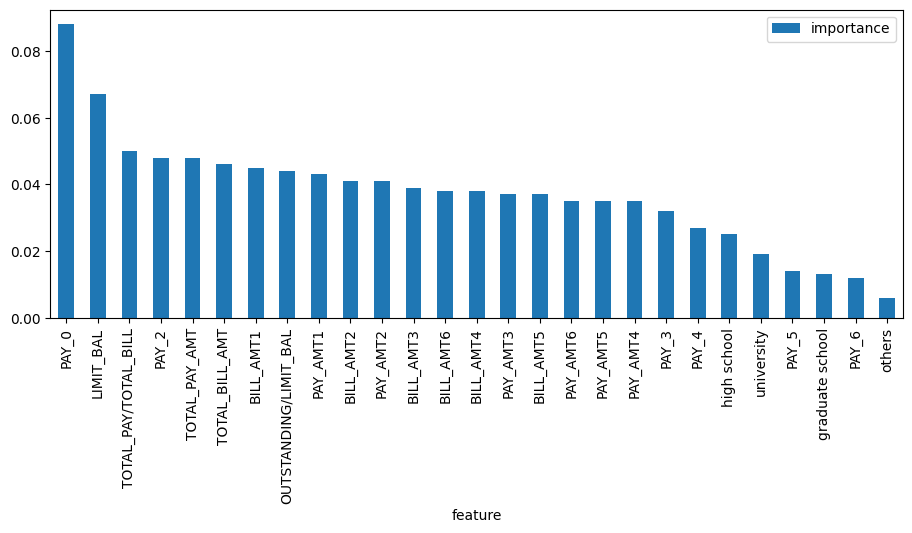

In [ ]:
score = np.round(model_rfgi.feature_importances_,3)
importances = pd.DataFrame({'feature':xs.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [ ]:
model_gb = GradientBoostingClassifier()
model_gb.fit(xs, ys)

GradientBoostingClassifier()

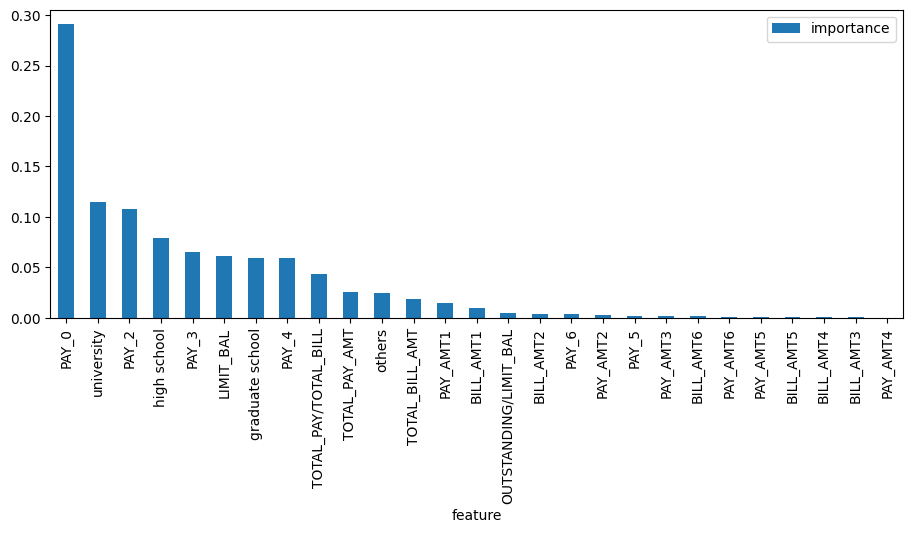

In [ ]:
model_gb.fit(xs, ys);
# extract important features
score = np.round(model_gb.feature_importances_,3)
importances = pd.DataFrame({'feature':xs.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [ ]:
X = xs.append(X_test)
y = ys.append(y_test)

In [ ]:
X.values
y.values

array([0, 0, 1, ..., 0, 1, 0])

In [ ]:
rfgi_tuned_params = {   "max_depth": sp_randint(1, 4),
                      "min_samples_leaf"  : sp_randint(2, 11),
                      'min_samples_split' : sp_randint(2, 11)}
n_iter_search = 20
random_search = RandomizedSearchCV(model_rfgi, rfgi_tuned_params,
                                   n_iter = n_iter_search, cv=10)

random_search.fit(X, y)
print("Best Params : ",random_search.best_params_,"\n")
best_rfgi = random_search.best_params_

means = random_search.cv_results_['mean_test_score']
stds = random_search.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, random_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best Params :  {'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 7} 

0.724 (+/-0.021) for {'max_depth': 1, 'min_samples_leaf': 9, 'min_samples_split': 4}
0.751 (+/-0.012) for {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.743 (+/-0.015) for {'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 7}
0.752 (+/-0.011) for {'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 7}
0.721 (+/-0.021) for {'max_depth': 1, 'min_samples_leaf': 7, 'min_samples_split': 2}
0.752 (+/-0.012) for {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 8}
0.752 (+/-0.013) for {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10}
0.722 (+/-0.014) for {'max_depth': 1, 'min_samples_leaf': 7, 'min_samples_split': 8}
0.724 (+/-0.018) for {'max_depth': 1, 'min_samples_leaf': 6, 'min_samples_split': 4}
0.745 (+/-0.012) for {'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 5}
0.722 (+/-0.023) for {'max_depth': 1, 'min_samples_leaf': 6, 'min

In [ ]:
model_rfgi2 = RandomForestClassifier(criterion='gini', max_depth= best_rfgi['max_depth'], min_samples_leaf= best_rfgi['min_samples_leaf'], min_samples_split= best_rfgi['min_samples_split'])

In [ ]:
model_rfgi2.fit(xs, ys)

RandomForestClassifier(max_depth=3, min_samples_leaf=10, min_samples_split=7)

In [ ]:
model_rfgi2.predict(X_test)
model_rfgi2.score(X_test,y_test)

0.8121666666666667

In [ ]:
rfgiprob = model_rfgi2.predict_proba(X_test)
rfgipredprob = pd.DataFrame({"probabilities":list(rfgiprob)})

In [ ]:
X_testdf = pd.DataFrame(X_test, columns = X.columns)

In [ ]:
X_testdf['RFGIPROBABILITIES'] = rfgipredprob.values
X_testdf[['RFGI_PROB_NONDEFAULT','RFGI_PROB_DEFAULT']] = pd.DataFrame(X_testdf.RFGIPROBABILITIES.values.tolist(), index= X_testdf.index)
X_testdf.drop(['RFGIPROBABILITIES'], axis = 1, inplace=True)

In [ ]:
gb_tuned_params = {   "max_depth": sp_randint(1, 4),
                      "min_samples_leaf"  : sp_randint(2, 11),
                      'min_samples_split' : sp_randint(2, 11)}
# you can change it
n_iter_search = 20
random_search = RandomizedSearchCV(model_gb, gb_tuned_params,
                                   n_iter = n_iter_search, cv=5)

random_search.fit(X, y)
print("Best Params : ",random_search.best_params_,"\n")
best_gb = random_search.best_params_

means = random_search.cv_results_['mean_test_score']
stds = random_search.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, random_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best Params :  {'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 3} 

0.811 (+/-0.080) for {'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 2}
0.789 (+/-0.034) for {'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 7}
0.758 (+/-0.022) for {'max_depth': 1, 'min_samples_leaf': 6, 'min_samples_split': 4}
0.758 (+/-0.022) for {'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 4}
0.758 (+/-0.022) for {'max_depth': 1, 'min_samples_leaf': 7, 'min_samples_split': 10}
0.789 (+/-0.034) for {'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 8}
0.810 (+/-0.081) for {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 9}
0.758 (+/-0.022) for {'max_depth': 1, 'min_samples_leaf': 7, 'min_samples_split': 9}
0.758 (+/-0.022) for {'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 6}
0.758 (+/-0.022) for {'max_depth': 1, 'min_samples_leaf': 8, 'min_samples_split': 2}
0.758 (+/-0.022) for {'max_depth': 1, 'min_samples_leaf': 2, 'min

In [ ]:
model_gb2 = GradientBoostingClassifier(max_depth= best_gb["max_depth"], min_samples_leaf= best_gb["min_samples_leaf"], min_samples_split= best_gb["min_samples_split"])

In [ ]:
model_gb2.fit(xs, ys)

GradientBoostingClassifier(min_samples_leaf=10, min_samples_split=3)

In [ ]:
model_gb2.score(X_test,y_test)

0.8223333333333334

In [ ]:
gbprob = model_gb2.predict_proba(X_test)
gbpredprob = pd.DataFrame({"probabilities":list(gbprob)})

In [ ]:
X_testdf['GBPROBABILITIES'] = gbpredprob.values
X_testdf[['GB_PROB_NONDEFAULT','GB_PROB_DEFAULT']] = pd.DataFrame(X_testdf.GBPROBABILITIES.values.tolist(), index= X_testdf.index)
X_testdf.drop(['GBPROBABILITIES'], axis = 1, inplace=True)

In [ ]:
def fig_roc(clf,X_train, X_test, y_train, y_test):
    clf.fit(X_train,y_train)
    y_scores = clf.predict_proba(X_test)[:, 1]  # Probability estimates for positive class
    fp,tp,thresholds=roc_curve(y_test, y_scores, pos_label=1)
    AUC=auc(fp,tp)*100
    plt.plot(fp, tp, color='blue',label = 'AUC = %0.2f' % AUC)
    t=str(clf)
    plt.title('Receiver Operating Characteristic'+t)
    
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

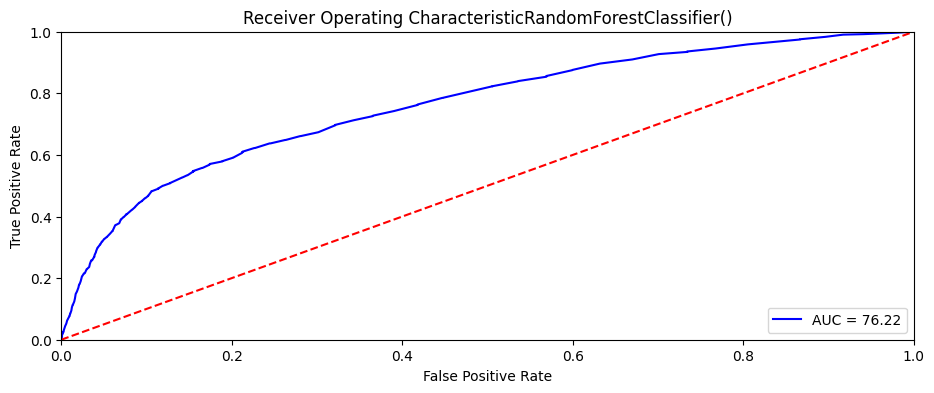

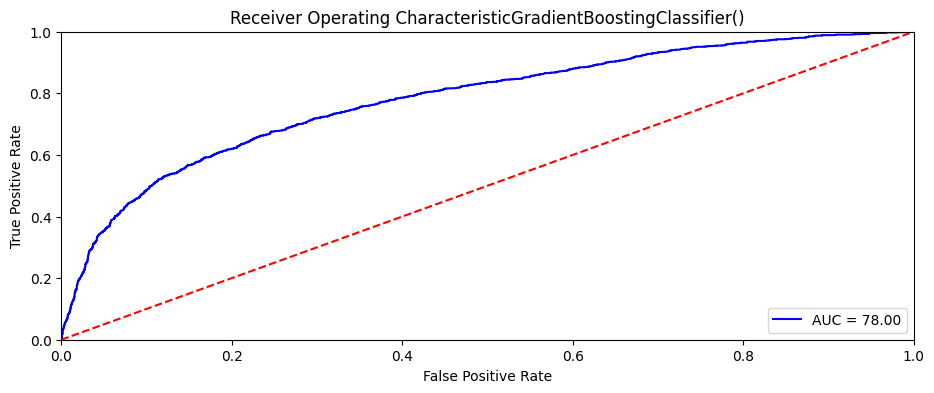

In [ ]:
fig_roc(model_rfgi,xs, X_test, ys, y_test)
fig_roc(model_gb,xs, X_test, ys, y_test)

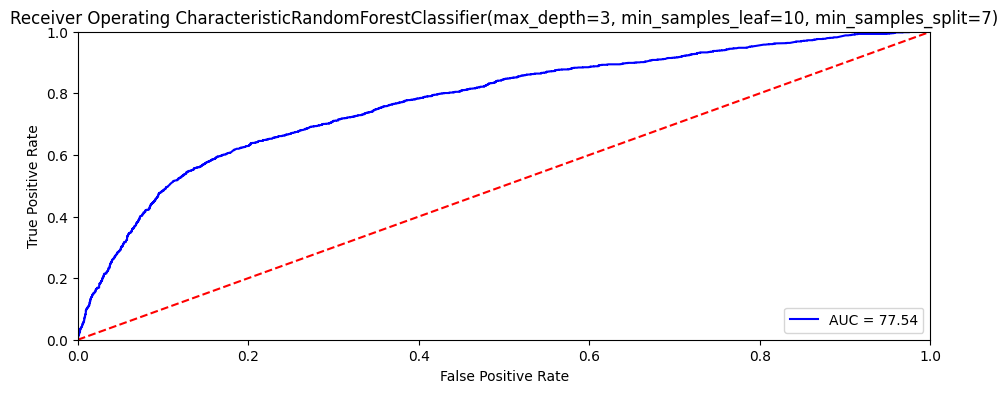

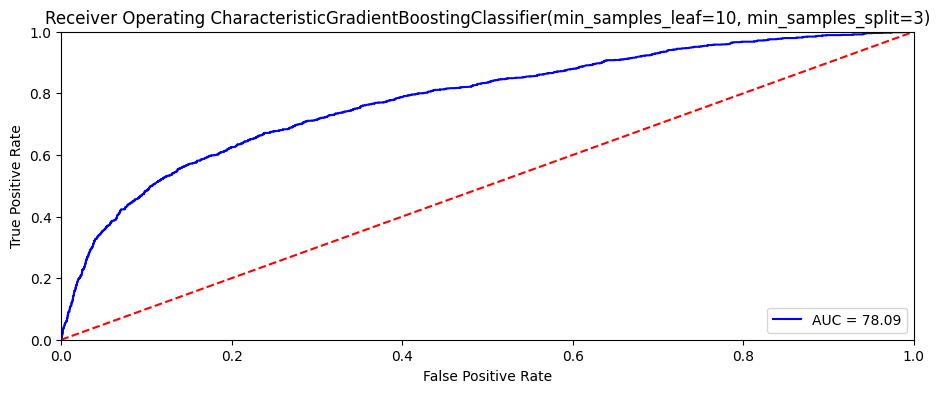

In [ ]:
fig_roc(model_rfgi2,xs, X_test, ys, y_test)
fig_roc(model_gb2,xs, X_test, ys, y_test)

In [ ]:
rf_probabilities1 = model_rfgi2.predict_proba(X_test)[:, 1] 
gb_probabilities1 = model_gb2.predict_proba(X_test)[:, 1] 
correlation_coefficient = np.corrcoef(rf_probabilities1, gb_probabilities1)[0, 1]
print("Correlation Coefficient:", correlation_coefficient)

Correlation Coefficient: 0.9290607819752282


In [ ]:
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(estimators=[
    ('rf', model_rfgi2),
    ('gb', model_gb2),
], voting = 'soft')
ensemble_model.fit(xs, ys)
ensemble_predictions = ensemble_model.predict(X_test)

ensemble_score = ensemble_model.score(X_test, y_test)
print("Ensemble Model Score: ", ensemble_score)

Ensemble Model Score:  0.8235


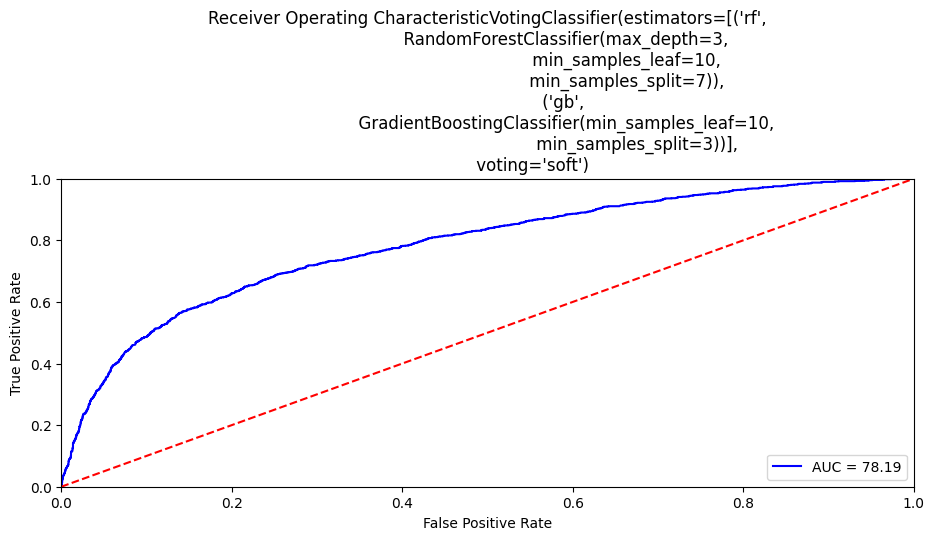

In [ ]:
fig_roc(ensemble_model, xs, X_test, ys, y_test)

**Can we estimate sensitive information of credit card holders based on other information?**

In [ ]:
sensitive_info_data = pd.read_csv("default of credit card clients.csv")

In [ ]:
X_sex = sensitive_info_data.drop(['SEX'], axis=1)
y_sex = sensitive_info_data["SEX"]
X_train_sex, X_test_sex, y_train_sex, y_test_sex = train_test_split(X_sex,
                                                    y_sex,
                                                    test_size = 0.2, random_state = 45)

In [ ]:
model_gb2.fit(X_train_sex, y_train_sex)

GradientBoostingClassifier(min_samples_leaf=10, min_samples_split=3)

In [ ]:
model_gb2.score(X_test_sex,y_test_sex)

0.8051666666666667

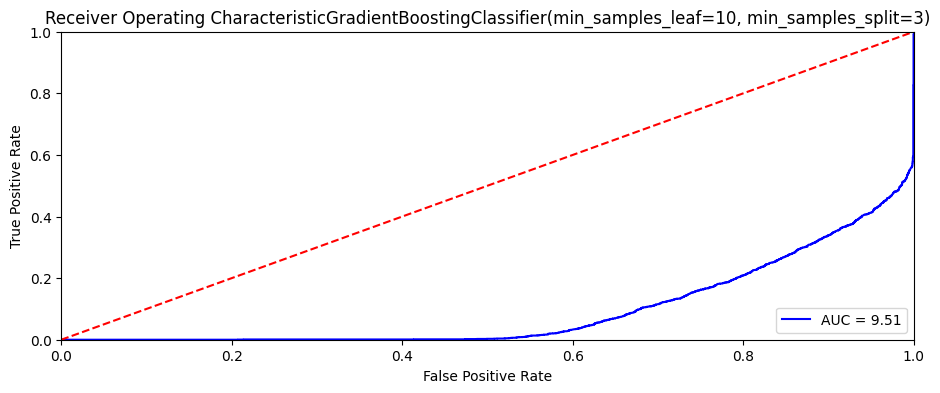

In [ ]:
fig_roc(model_gb2,X_train_sex, X_test_sex, y_train_sex, y_test_sex)

In [ ]:
X_marriage = sensitive_info_data.drop(['MARRIAGE'], axis=1)
y_marriage = sensitive_info_data["MARRIAGE"]
X_train_marriage, X_test_marriage, y_train_marriage, y_test_marriage = train_test_split(X_marriage,
                                                    y_marriage,
                                                    test_size = 0.2, random_state = 45)

In [ ]:
model_gb2.fit(X_train_marriage, y_train_marriage)

GradientBoostingClassifier(min_samples_leaf=10, min_samples_split=3)

In [ ]:
model_gb2.score(X_test_marriage,y_test_marriage)

0.7305

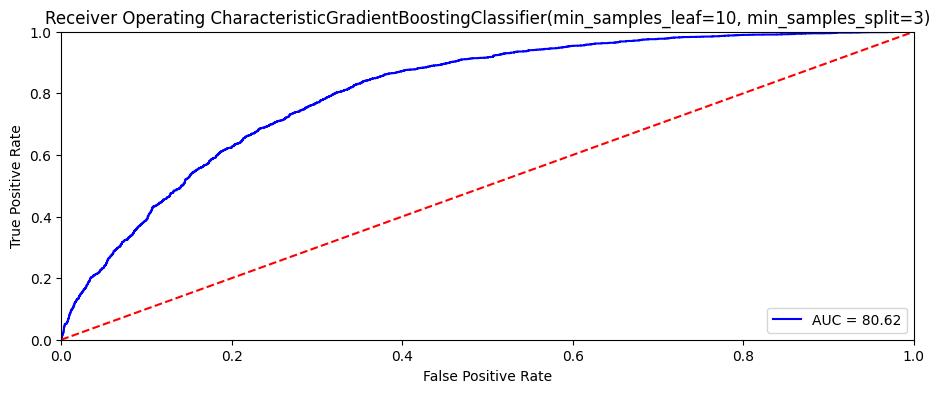

In [ ]:
fig_roc(model_gb2,X_train_marriage, X_test_marriage, y_train_marriage, y_test_marriage)

**What's the most important information for credit card company?**

In [ ]:
classification_data = pd.read_csv("default of credit card clients.csv")

In [ ]:
sensitive_columns = ['SEX', 'MARRIAGE', 'AGE']
data_without_sensitive = classification_data.drop(sensitive_columns, axis = 1)

In [ ]:
mask_columns = ['PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                   'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
classification_data1 = data_without_sensitive.drop(mask_columns, axis=1)

In [ ]:
classification_X1 = classification_data1.drop(['default payment next month'], axis=1)
classification_y1 = classification_data["default payment next month"]

X_train1, X_test1, y_train1, y_test1 = train_test_split(classification_X1,
                                                    classification_y1,
                                                    test_size = 0.2, random_state = 45)

In [ ]:
mask_columns = ['PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                   'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
classification_data2 = data_without_sensitive.drop(mask_columns, axis=1)

In [ ]:
classification_X2 = classification_data2.drop(['default payment next month'], axis=1)
classification_y2 = classification_data["default payment next month"]

X_train2, X_test2, y_train2, y_test2 = train_test_split(classification_X2,
                                                    classification_y2,
                                                    test_size = 0.2, random_state = 45)

In [ ]:
mask_columns = ['PAY_4', 'PAY_5', 'PAY_6',
                   'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                   'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
classification_data3 = data_without_sensitive.drop(mask_columns, axis=1)

In [ ]:
classification_X3 = classification_data3.drop(['default payment next month'], axis=1)
classification_y3 = classification_data["default payment next month"]

X_train3, X_test3, y_train3, y_test3 = train_test_split(classification_X3,
                                                    classification_y3,
                                                    test_size = 0.2, random_state = 45)

In [ ]:
mask_columns = ['PAY_5', 'PAY_6',
                   'BILL_AMT5', 'BILL_AMT6',
                   'PAY_AMT5', 'PAY_AMT6']
classification_data4 = data_without_sensitive.drop(mask_columns, axis=1)

In [ ]:
classification_X4 = classification_data4.drop(['default payment next month'], axis=1)
classification_y4 = classification_data["default payment next month"]

X_train4, X_test4, y_train4, y_test4 = train_test_split(classification_X4,
                                                    classification_y4,
                                                    test_size = 0.2, random_state = 45)

In [ ]:
mask_columns = ['PAY_6',
                   'BILL_AMT6',
                  'PAY_AMT6']
classification_data5 = data_without_sensitive.drop(mask_columns, axis=1)

In [ ]:
classification_X5 = classification_data4.drop(['default payment next month'], axis=1)
classification_y5 = classification_data["default payment next month"]

X_train5, X_test5, y_train5, y_test5 = train_test_split(classification_X5,
                                                    classification_y5,
                                                    test_size = 0.2, random_state = 45)

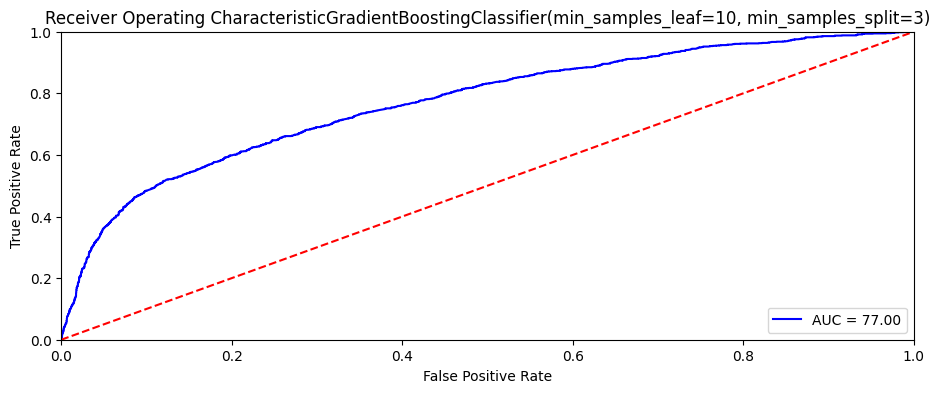

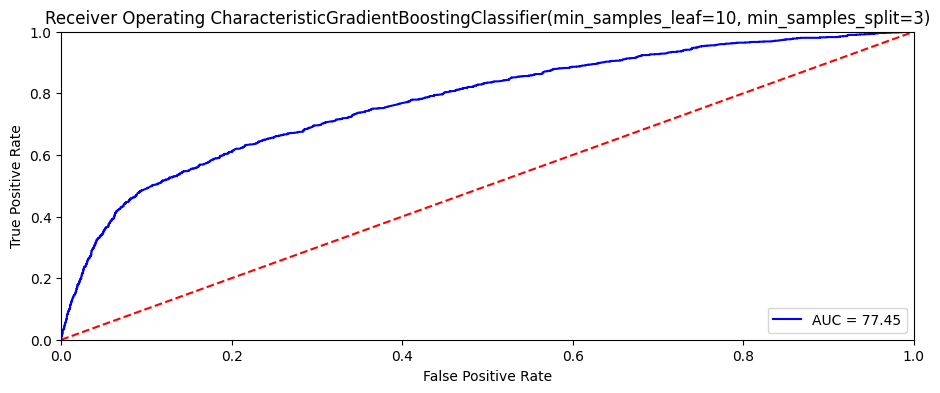

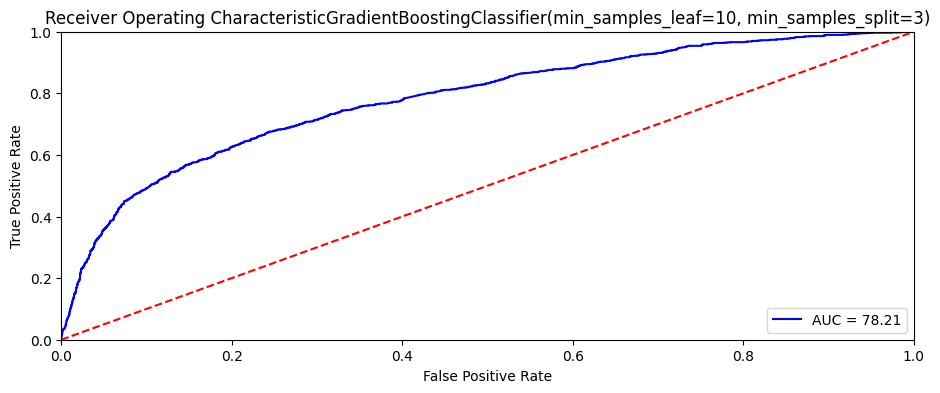

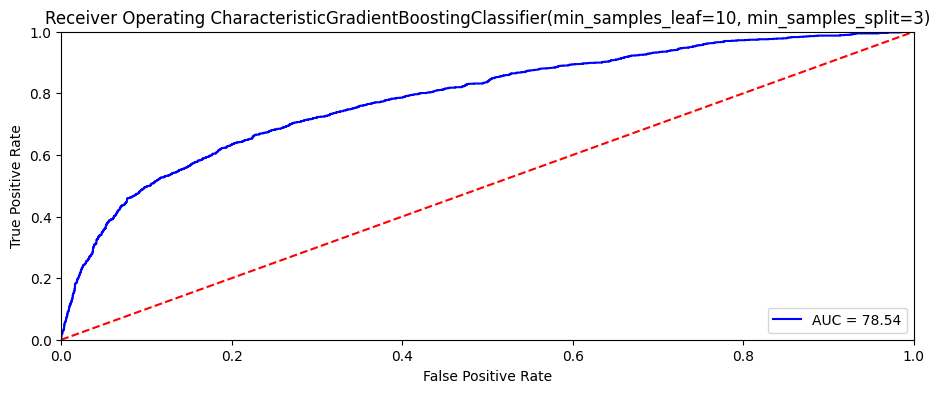

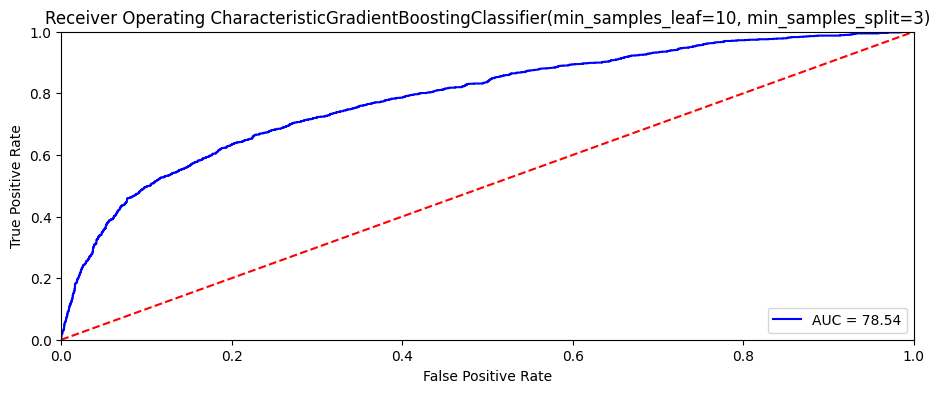

Dataset1: 0.8253333333333334
Dataset2: 0.8241666666666667
Dataset3: 0.8248333333333333
Dataset4: 0.826
Dataset5: 0.826


In [ ]:
scores = []
dataset_names = []

# Iterate over the datasets
for i in range(1, 6):  # Assuming you have 5 datasets: X_train1, X_train2, ..., X_train5
    # Train the model on the current training dataset
    model_gb2.fit(eval(f'X_train{i}'), eval(f'y_train{i}'))
    
    # Calculate the score for the current test dataset
    score = model_gb2.score(eval(f'X_test{i}'), eval(f'y_test{i}'))
    
    # Append the score and dataset name to the respective lists
    scores.append(score)
    dataset_names.append(f'Dataset{i}')
    fig_roc(model_gb2,eval(f'X_train{i}'), eval(f'X_test{i}'), eval(f'y_train{i}'), eval(f'y_test{i}'))

# Print the scores and dataset names
for dataset_name, score in zip(dataset_names, scores):
    print(f'{dataset_name}: {score}')
    

<Axes: xlabel='GB_PROB_DEFAULT', ylabel='Density'>

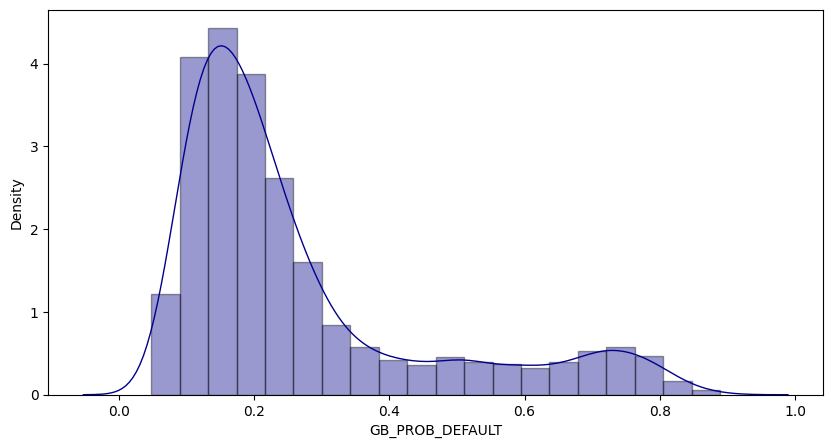

In [ ]:
plt.figure(figsize=(10,5))

sns.distplot(X_testdf['GB_PROB_DEFAULT'], hist=True, kde=True, bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 1})


In [ ]:
X_testdf['RISK'] = pd.cut(X_testdf['GB_PROB_DEFAULT'], bins=[0.000, 0.200, 0.600,1.000], labels=['LOW_RISK','MEDIUM_RISK','HIGH_RISK'])

X_testdf['RISK'].value_counts()

LOW_RISK       3102
MEDIUM_RISK    2279
HIGH_RISK       619
Name: RISK, dtype: int64

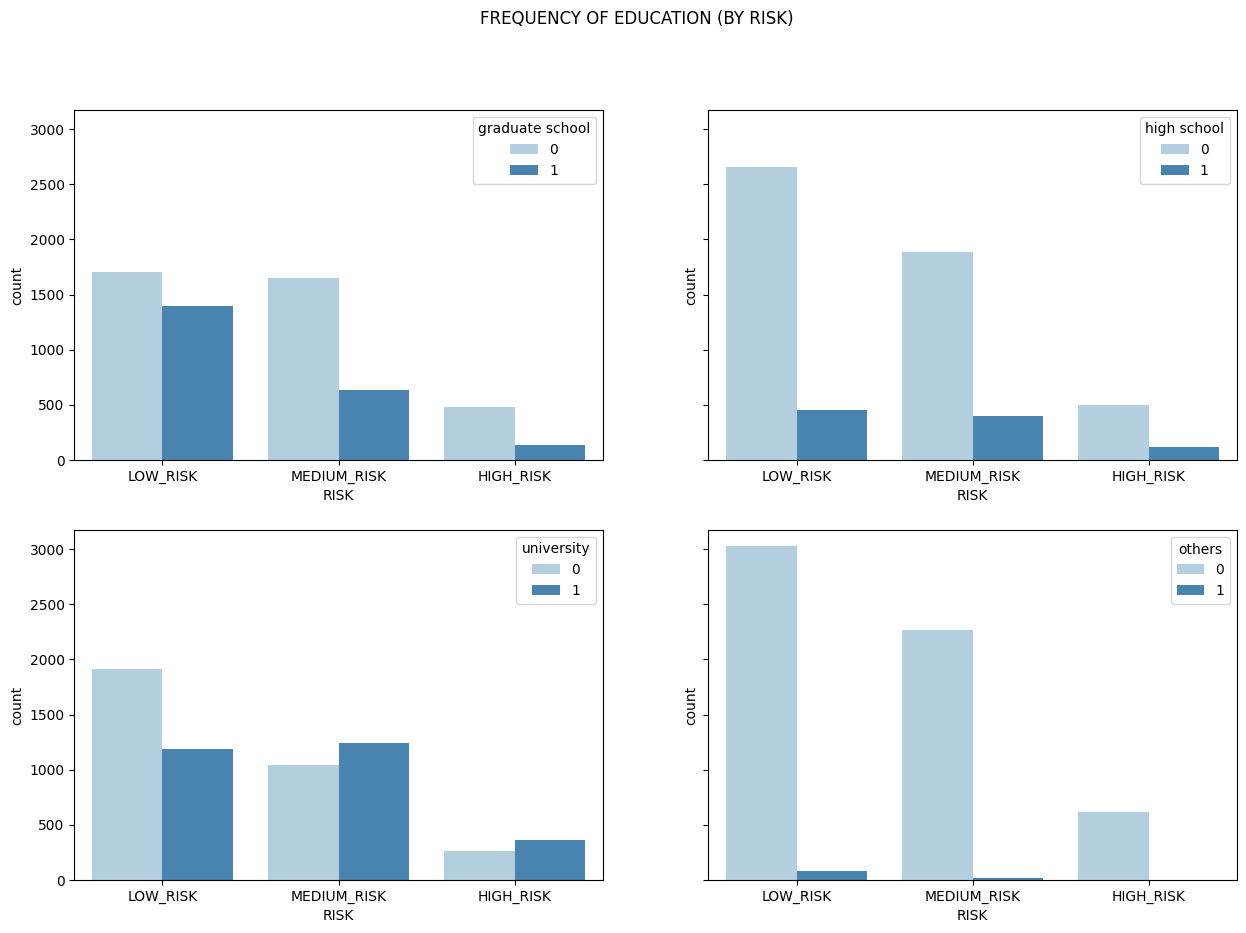

In [ ]:
#Get count plots for risk by education. 

f, axes = plt.subplots(2,2,figsize=(15, 10), facecolor='white',sharey=True)
f.suptitle('FREQUENCY OF EDUCATION (BY RISK)')
ax1 = sns.countplot(x="RISK", hue="graduate school", data=X_testdf, palette="Blues", ax=axes[0,0])
ax2 = sns.countplot(x="RISK", hue="high school", data=X_testdf, palette="Blues", ax=axes[0,1])
ax3 = sns.countplot(x="RISK", hue="university", data=X_testdf, palette="Blues", ax=axes[1,0])
ax4 = sns.countplot(x="RISK", hue="others", data=X_testdf, palette="Blues", ax=axes[1,1])

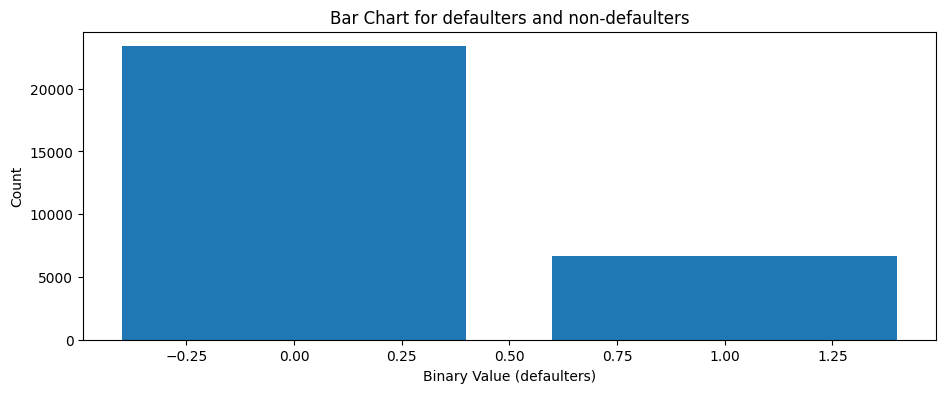

In [ ]:
value_counts = df['default payment next month'].value_counts()

# Create the bar chart
plt.bar(value_counts.index, value_counts.values)

# Set the labels and title
plt.xlabel('Binary Value (defaulters)')
plt.ylabel('Count')
plt.title('Bar Chart for defaulters and non-defaulters')

# Show the plot
plt.show()

In [ ]:
df1 = pd.DataFrame()
df1['PAY_1 || PAY_2'] = ((df['PAY_0'] == -1) | (df['PAY_2'] == -1)).astype(int)
df1['PAY_1 & PAY_2'] = ((df['PAY_0'] == -1) & (df['PAY_2'] == -1)).astype(int)
df1['default payment next month'] = df['default payment next month']
df1.head()

,PAY_1 || PAY_2,PAY_1 & PAY_2,default payment next month
0,0,0,1
1,1,0,1
2,0,0,0
3,0,0,0
4,1,0,0


**is default affected by pay_1 and pay_2 result?**

Does pay_1 and pay_2 results affect the default rate? I will try to answer this question with a hypothesis test. As is customary, I'll use a significance level of α = 0.05. Then the bounds of the confidence interval are given by [α/2, 1-α/2] = [0.025,0.975].

In [ ]:
alpha = 0.05
lb, ub = (alpha / 2), 1 - (alpha / 2)
ci_bounds = [lb, ub]

In [ ]:
from scipy import stats

ttest, pval = stats.ttest_ind(df1[df1['PAY_1 || PAY_2'] == 1]['default payment next month'], df1[df1['PAY_1 || PAY_2'] == 0]['default payment next month'], equal_var=False)

In [ ]:
print(pval)

if pval < 0.05:
    print("The null hypothesis is rejected.")
else:
    print("The null hypothesis is accepted.")

4.765271286341173e-35
The null hypothesis is rejected.


In [ ]:
ttest1, pval1 = stats.ttest_ind(df1[df1['PAY_1 & PAY_2'] == 1]['default payment next month'], df1[df1['PAY_1 & PAY_2'] == 0]['default payment next month'], equal_var=False)

In [ ]:
print(pval1)

if pval1 < 0.05:
    print("The null hypothesis is rejected.")
else:
    print("The null hypothesis is accepted.")

2.6297869744762125e-43
The null hypothesis is rejected.


**Dimensionality Reduction with PCA**

In [ ]:
df = pd.read_csv("default of credit card clients.csv")
y = df['default payment next month']    
X = df.drop('default payment next month', axis = 1, inplace = False)
X_train_val, X_test_reduced, y_train_val, y_test_reduced = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

Actual number of components: 24


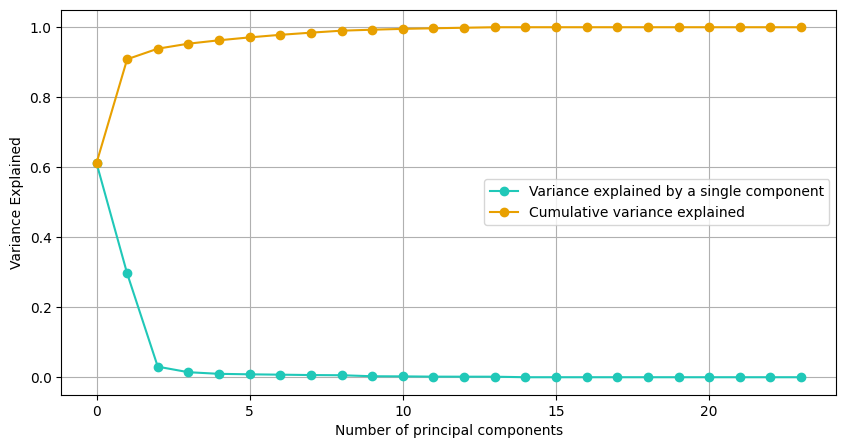

In [ ]:
from sklearn.decomposition import PCA

print(f"Actual number of components: {len(X_train_val.columns.values)}")

n_pc = len(X_train_val.columns.values) 

pca = PCA(n_components=n_pc)
pca.fit(X_train_val)

fig=plt.figure(1, figsize=(10,5))
plt.grid(True, which='major', axis='both')
plt.plot(pca.explained_variance_ratio_, marker='o', color='#20c8b8')
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='#e8a000')

plt.legend(["Variance explained by a single component", "Cumulative variance explained"])
plt.xlabel('Number of principal components')
plt.ylabel('Variance Explained')
plt.savefig("PCA")

In [ ]:
n_pc = 12
pca = PCA(n_components=n_pc)
pca.fit(X_train_val)

X_12d_train = pd.DataFrame(pca.transform(X_train_val))
X_12d_test = pd.DataFrame(pca.transform(X_test_reduced))
X_12d_train.columns = ['PC' + str(i) for i in range(1, n_pc+1) ]
X_12d_test.columns = ['PC' + str(i) for i in range(1, n_pc+1) ]

In [ ]:
clf_rfgi_PCA=RandomForestClassifier(criterion='gini')
clf_rfgi_PCA.fit(X_12d_train,y_train_val)

RandomForestClassifier()

In [ ]:
gb_clf_PCA=GradientBoostingClassifier()
gb_clf_PCA.fit(X_12d_train,y_train_val)

GradientBoostingClassifier()

In [ ]:
print("Score of Random Forest Model with PCA on train: ","{0:.4f}".format(clf_rfgi_PCA.score(X_12d_train,y_train_val)))

Score of Random Forest Model with PCA on train:  1.0000


In [ ]:
print("Score of Gradient Boosting Model with PCA on train: ","{0:.4f}".format(gb_clf_PCA.score(X_12d_train,y_train_val)))  

Score of Gradient Boosting Model with PCA on train:  0.7879


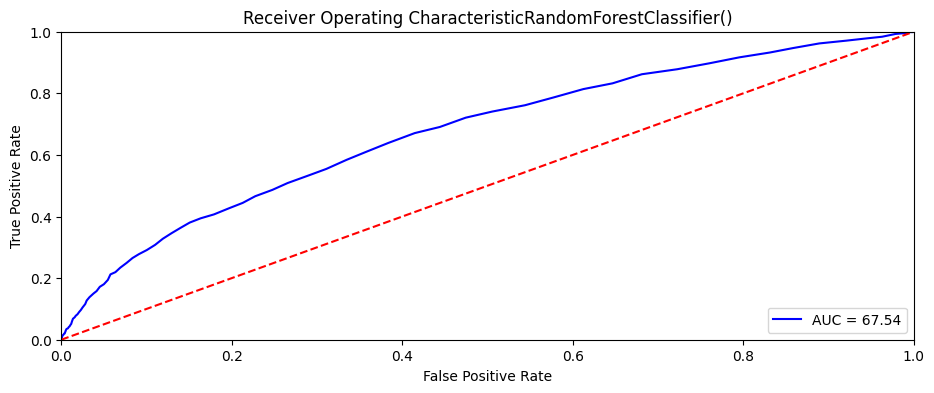

In [ ]:
fig_roc(clf_rfgi_PCA, X_12d_train, X_12d_test, y_train_val, y_test_reduced)

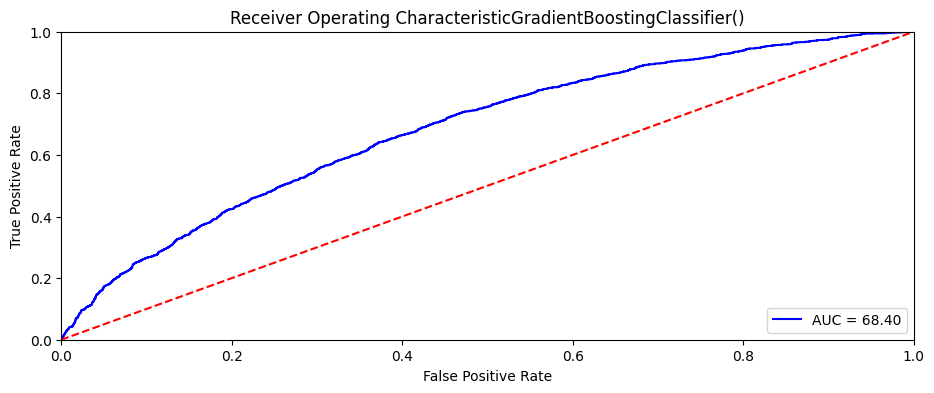

In [ ]:
fig_roc(gb_clf_PCA, X_12d_train, X_12d_test, y_train_val, y_test_reduced)

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=12, n_neighbors=10)
X_reduced = lle.fit_transform(xs)

In [ ]:
clf_rfgi_lle=RandomForestClassifier(criterion='gini')
clf_rfgi_lle.fit(X_reduced,ys)

RandomForestClassifier()

In [ ]:
gb_clf_lle=GradientBoostingClassifier()
gb_clf_lle.fit(X_reduced,ys)

GradientBoostingClassifier()

In [ ]:
print("Score of Random Forest Model with LLE on train: ","{0:.4f}".format(clf_rfgi_lle.score(X_reduced,ys)))

Score of Random Forest Model with LLE on train:  0.9663


In [ ]:
print("Score of Gradient Boosting Model with LLE on train: ","{0:.4f}".format(gb_clf_lle.score(X_reduced,ys)))   

Score of Gradient Boosting Model with LLE on train:  0.6815


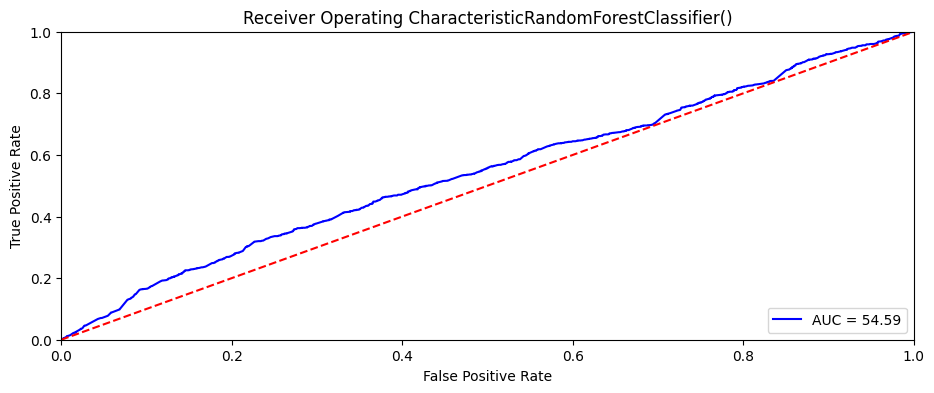

In [ ]:
fig_roc(clf_rfgi_lle, X_reduced, X_12d_test, ys, y_test_reduced)

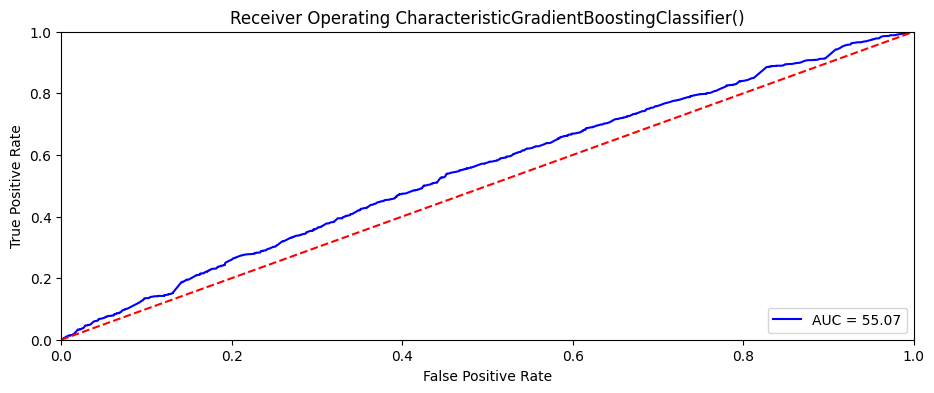

In [ ]:
fig_roc(gb_clf_lle, X_reduced, X_12d_test, ys, y_test_reduced)